In [1]:
import glob, os, sys
sys.path.append("..")
from utils.utils import *
import uproot, ROOT, random, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from xgboost import XGBClassifier 

# Set up plot defaults
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

Welcome to JupyROOT 6.28/04


In [2]:
Ztt_inc_dsid = [
    # mc23 DSIDs
    # 700621, 700622, 700623, 
    # 700642, 700643, 700644,
    # 700703, 700704, 700705,
    # mc20 DSIDs
    700792, 700793, 700794,
    700360, # Ztautau2jets
    ]
ttV_dsid = [
    410155, # ttW
    410218, 410219, 410220, # ttZ
    304014, 410220 # 3t, 4t #! missing these samples
    ]

# Diboson
VV_dsid = [
    700488, 700489, 
    700491, 700492, 700493, 700494, 700495, 700496,
    700600, 700601, 700602, 700603, 700604, 700605, 
]

# Single-Top and ttbar (new samples now!)
Top_dsid = [
    410470, 410471, 
    # 410472, 
    410644, 410645, 410646, 410647, 
    410658, 410659
]

# W(tau/mu/e + nu) + jets
W_dsid = [
    700338, 700339, 700340, # Wenu
    700341, 700342, 700343, # Wmunus
    700344, 700345, 700346, # WtaunuL
    700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
    700362, 700363, 700364, # W lep + 2jets
]

Zll_inc_dsid = [
    700320, 700321, 700322, # Zee 
    700323, 700324, 700325, # Zmumu
    700358, #Zee2jets
    700359, #Zmumu2jets
]

# Signal samples (new)
ggH_dsid = [
    # mc23 DSIDs
    # 601578, 601579, 601580, 601581, 
    # mc20 DSIDs
    345120, 345122, 345123, 345121
    ]
VBFH_dsid = [
    # mc20 DSIDs
    346190, 346191, 346192, 346193,
]
WH_dsid = [345211, 345212]
ZH_dsid = [345217]
ttH_dsid = [346343,346344,346345]


In [3]:
def read_event_weights(event_id, data_year):
    file_path = './xsec_sumofweights_nom.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])

    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            results[event_id] = event_weight / sum_event_weights
    return results
            
#signal
vbfh_ws = fetch_weights(VBFH_dsid, 'mc20e')
ggh_ws = fetch_weights(ggH_dsid, 'mc20e')
wh_ws = fetch_weights(WH_dsid, 'mc20e')
zh_ws = fetch_weights(ZH_dsid, 'mc20e')
tth_ws = fetch_weights(ttH_dsid, 'mc20e')

#background
ztt_ws = fetch_weights(Ztt_inc_dsid, 'mc20e')
ttv_ws = fetch_weights(ttV_dsid, 'mc20e')
vv_ws = fetch_weights(VV_dsid, 'mc20e')
top_ws = fetch_weights(Top_dsid, 'mc20e')
w_ws = fetch_weights(W_dsid, 'mc20e')
zll_ws = fetch_weights(Zll_inc_dsid, 'mc20e')

In [4]:
branches = \
['HLT_j420',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111',
 'ditau_obj_IsTruthMatched',
 'ditau_obj_truth_p4',
 'jets_b_tag_score',
 'ditau_obj_bdt_score',
#  'ditau_obj_charge',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
#  'ditau_obj_n_iso_tracks',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
#  'ditau_obj_subjets_dR',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'ditau_obj_mvis_recalc',
 'event_number',
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'met_truth_p4',
 'event_is_bad_batman',
 'NOMINAL_pileup_combined_weight',
 'n_bjets_DL1dv01_FixedCutBEff_70',
 'weight_mc']

data_branches = \
['HLT_j420',
 'event_number',    
 'ditau_obj_IsTruthMatched',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111',
 'ditau_obj_mvis_recalc',
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'met_truth_p4',
 'event_is_bad_batman',
 'jets_b_tag_score',
 'ditau_obj_bdt_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [5]:
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/mc/ditau_hh/mc20e/nom/user.shhirose.*{dsid}.*/user.*.root'
def read_root(dsid_list, mc_ws):
    out = []
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid)
        files = glob.glob(file_pattern)
        s = time.time()
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                events = f_1.arrays(branches, library='ak')
                events['weight'] = mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])
                out = ak.concatenate((out, events))
        print("Processed:", len(files), "files for DSID", dsid, "Time spent:", round(time.time()-s, 4), 's')
    return out

vbfh = read_root(VBFH_dsid, vbfh_ws)
ggh = read_root(ggH_dsid, ggh_ws)
wh = read_root(WH_dsid, wh_ws)
zh = read_root(ZH_dsid, zh_ws)
tth = read_root(ttH_dsid, tth_ws)

ztt = read_root(Ztt_inc_dsid, ztt_ws)
ttv = read_root(ttV_dsid, ttv_ws)
vv = read_root(VV_dsid, vv_ws)
top = read_root(Top_dsid, top_ws)
w = read_root(W_dsid, w_ws)
zll = read_root(Zll_inc_dsid, zll_ws)

Processed: 1 files for DSID 346190 Time spent: 0.2622 s
Processed: 1 files for DSID 346191 Time spent: 0.36 s
Processed: 1 files for DSID 346192 Time spent: 0.2716 s
Processed: 1 files for DSID 346193 Time spent: 0.5392 s
Processed: 3 files for DSID 345120 Time spent: 0.8821 s
Processed: 2 files for DSID 345122 Time spent: 0.6453 s
Processed: 2 files for DSID 345123 Time spent: 0.6241 s
Processed: 2 files for DSID 345121 Time spent: 0.6848 s
Processed: 1 files for DSID 345211 Time spent: 0.2717 s
Processed: 1 files for DSID 345212 Time spent: 0.4055 s
Processed: 1 files for DSID 345217 Time spent: 0.2647 s
Processed: 3 files for DSID 346343 Time spent: 1.0224 s
Processed: 1 files for DSID 346344 Time spent: 0.3739 s
Processed: 1 files for DSID 346345 Time spent: 0.3157 s
Processed: 8 files for DSID 700792 Time spent: 3.6768 s
Processed: 6 files for DSID 700793 Time spent: 5.8011 s
Processed: 36 files for DSID 700794 Time spent: 30.3969 s
Processed: 2 files for DSID 700360 Time spent: 0

In [6]:
## load data
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/*.root'

def read_data_root(file_paths):
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        print("reading: ", l1[i])
        f_1 = uproot.open(l1[i]+':NOMINAL')
        events = f_1.arrays(data_branches, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1[i], "time spent", round(time.time()-s, 4), 's')
    return out

data = read_data_root(path_template_data)

reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000178.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000165.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000156.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000101.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/dita

In [7]:
def Cut(t):
    cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
                   (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & #b veto
                   (t['ditau_obj_IsTruthMatched']==1) &
                   (t['ditau_obj_bdt_score'] >= 0.72) &
                   (t['event_is_bad_batman'] == 0) &
                   (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
                   (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & ### last 2 cuts are in ntuples now
                   (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
                   (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
                   ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))
    return t[cut]

def data_Cut(t):
    cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
                   (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) &
                   (t['ditau_obj_bdt_score'] < 0.72) &
                   (t['event_is_bad_batman'] == 0) &
                   (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
                   (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) &
                   (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
                   (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
                   ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))
    return t[cut]

In [8]:
ggh_cut = Cut(ggh)
vbfh_cut = Cut(vbfh)
wh_cut = Cut(wh)
zh_cut = Cut(zh)
tth_cut = Cut(tth)

vv_cut = Cut(vv)
top_cut = Cut(top)
ztt_cut = Cut(ztt)
ttv_cut = Cut(ttv)
w_cut = Cut(w)
zll_cut = Cut(zll)

print(len(zll_cut))
print(len(vbfh_cut))


23621
2068


In [9]:
data_cut = data_Cut(data)

In [10]:
# #print number of events after each cut for all samples
# #first make a fucntion to print the number of events after each cut
# def Printcut(t):
#     # print skip line for each sample
#     # print("  ", end='\n')
#     print(len((t['ditau_obj_nSubjets'])), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) & (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) & ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))[0]))


# Printcut(ggh)
# Printcut(vbfh)
# Printcut(wh)
# Printcut(zh)
# Printcut(tth)

In [11]:
# Printcut(vv)
# Printcut(top)
# Printcut(ztt)
# Printcut(ttv)
# Printcut(w)
# Printcut(zll)

In [12]:
###slower code for collieanr mass calc####
# def collinear_mass_calc(k1, k2, metetx, metety):
#     collinear_mass = []
#     for i in range(len(metetx)):
#         k1_sub = vector.obj(px=k1.px[i], py=k1.py[i], pz=k1.pz[i], energy=k1.energy[i])
#         k2_sub = vector.obj(px=k2.px[i], py=k2.py[i], pz=k2.pz[i], energy=k2.energy[i])
#         K = np.array([[k1_sub.px, k2_sub.px],
#                       [k1_sub.py, k2_sub.py]])
#         if np.linalg.det(K) == 0:
#            return -1
#         M = np.array([[metetx[i]],
#                       [metety[i]]])
#         Kinv = np.linalg.inv(K)
#         X = np.dot(Kinv, M)
#         X1 = X[0, 0]
#         X2 = X[1, 0]
#         x1 = 1. / (1. + X1)
#         x2 = 1. / (1. + X2)
#         p1 = k1_sub * (1 / x1)
#         p2 = k2_sub * (1 / x2)
#         collinear_mass.append((p1 + p2).mass)

#     return collinear_mass

In [13]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []

    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [14]:
# def collinear_mass_calc(k1_px, k1_py, k1_pz, k1_energy, k2_px, k2_py, k2_pz, k2_energy, metetx, metety):
#     collinear_mass = []

#     K = np.array([[k1_px, k2_px],
#                   [k1_py, k2_py]])
#     if np.linalg.det(K) == 0:
#         print("AAAAAA")
#         return 0
#     M = np.array([[metetx],
#                   [metety]])
    
#     Kinv = np.linalg.inv(K)
#     X = np.dot(Kinv, M)
#     X1 = X[0, 0]
#     X2 = X[1, 0]
    
#     x1 = 1. / (1. + X1)
#     x2 = 1. / (1. + X2)
    
#     p1 = vector.obj(px=k1_px, py=k1_py, pz=k1_pz, energy=k1_energy) * (1 / x1)
#     p2 = vector.obj(px=k2_px, py=k2_py, pz=k2_pz, energy=k2_energy) * (1 / x2)
    
#     collinear_mass.append((p1 + p2).mass)
    
#     return collinear_mass

# collinear_mass_calc(-0.989992, 0.14112, 3.62686, 4, 3.76951, 3.28493, 1008.57, 8, 9, 10)
# collinear_mass_calc(17.2739, 33.2716 , 38.9482, 4, 3.76951, 3.28493, 1008.57, 8, 9, 10)


In [15]:
ff_scale = 1

def determine_prong(leadNTracks, subleadNTracks):
    if leadNTracks == 1 and subleadNTracks == 1:
        return 1
    elif leadNTracks == 3 and subleadNTracks == 1:
        return 2
    elif leadNTracks == 1 and subleadNTracks == 3:
        return 2
    elif leadNTracks == 3 and subleadNTracks == 3:
        return 3
    else:
        return -1

def load_histograms(root_file):
    file = uproot.open(root_file)
    histograms = {
        "h_ff_1p1p": file["FF_1p1p_ditau_obj_subleadsubjet_pt"].to_hist(),
        "h_ff_1p3p": file["FF_1p3p_ditau_obj_subleadsubjet_pt"].to_hist(),
        "h_ff_3p3p": file["FF_3p3p_ditau_obj_subleadsubjet_pt"].to_hist()
    }
    return histograms

def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms):
    weights = []
    
    for lead, sublead, lead_pt, sublead_pt in zip(leadNTracks, subleadNTracks, lead_pt, sublead_pt):
        prongness = determine_prong(lead, sublead)
        weight = 0
        
        if prongness == 1:
            bin_idx = histograms["h_ff_1p1p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p1p"].values()[bin_idx]
        elif prongness == 2:
            bin_idx = histograms["h_ff_1p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p3p"].values()[bin_idx]
        elif prongness == 3:
            bin_idx = histograms["h_ff_3p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_3p3p"].values()[bin_idx]
        else:
            weight = -1
        
        weights.append(weight)
    
    return [w * ff_scale for w in weights]


In [16]:
# def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
#     d = np.sin(sublead_jet_phi - lead_jet_phi)
#     centrality = []
#     for i in range(len(d)):
#         if d[i] == 0:
#             centrality.append(-1234)
#         else:
#             #A = np.sin(met_phi - lead_jet_phi) / d
#             #B = np.sin(sublead_jet_phi - met_phi) / d
#             A = np.sin(met_phi[i] - lead_jet_phi[i]) / d[i]
#             B = np.sin(sublead_jet_phi[i] - met_phi[i]) / d[i]
#             centrality.append((A + B) / np.sqrt(A * A + B * B))
#     return centrality

def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [17]:
def Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                               py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                               pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                               energy=t['ditau_obj_leadsubjet_p4'].fE)
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                                  py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                                  pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                                  energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

    event_id = t['event_number']

    lumi_scale_factor = 58450.1 #for mc20e
    combined_weights = t['weight'] * t['weight_mc'] * t['NOMINAL_pileup_combined_weight'] * lumi_scale_factor 
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    # met_2d_truth = vector.obj(px=t['met_truth_p4'].fP.fX, py=t['met_truth_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######
    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val]

def Data_Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_leadsubjet_p4'].fE)                           
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
                          
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    # visible_ditau_m = t['ditau_obj_mvis_recalc']  
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass 

    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi

    event_id = t['event_number']
    ######
    histograms = load_histograms("ffs/FF_hadhad_ratio_1d.root")
    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms)
    ######
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######
    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val]


In [18]:
def cut_x1_x2(t):
    #cut_mask = np.where((np.array(t[6]) > -2.) & (np.array(t[6]) < 2.) & (np.array(t[7]) > -2.) & (np.array(t[7]) < 2.) & (np.array(t[16]) > 0.))[0]
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[16]) > 0.))[0]
    # cut_mask = np.where((np.array(t[16]) > 0.))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [19]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)

vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'met_centrality']

#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)


In [20]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,event_number,k_t,kappa,delta_R,delta_phi,delta_eta,combined_weights,fake_factor,delta_R_lead,met_centrality
0,538.078688,454.704156,25.682889,33.888864,44.850841,44.644235,1.261332,0.340896,0.091293,2.035712,480494748.0,6.094310,0.012686,0.237291,-0.075515,0.224954,1.0,0.004711,0.024447,-0.418356
1,508.921094,413.315250,24.097494,37.579012,8.423738,64.389632,1.184453,0.281727,0.016643,2.831157,504447465.0,8.506678,0.019448,0.353011,-0.125690,0.329877,1.0,0.003944,0.027496,-0.032899
2,492.924937,365.323438,10.964622,31.198884,78.134463,83.743483,1.980624,0.047179,0.155826,-1.050223,428336028.0,4.216670,0.011206,0.384571,0.335235,-0.188446,1.0,0.003944,0.006159,0.141881
3,429.751781,342.924906,17.127457,33.264732,35.925599,46.648418,0.954874,0.459574,0.073605,0.743481,441195059.0,6.033547,0.016757,0.352273,-0.306564,-0.173537,1.0,0.003944,0.050619,1.406000
4,457.772500,381.131844,10.149227,53.754080,20.009019,59.119526,0.952865,0.862389,0.039762,0.086594,448125636.0,8.646350,0.022098,0.851922,-0.805664,-0.276906,1.0,0.003944,0.031083,1.081917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41451,451.023469,290.138281,99.406023,43.252787,30.199518,24.160822,0.719048,15.312334,0.061769,1.313869,792995349.0,22.176904,0.056930,0.223094,0.216934,0.052062,1.0,0.023688,0.054446,0.139526
41452,598.484375,291.808125,234.925297,60.165496,36.151171,60.503355,0.749992,1.354086,0.061661,2.812273,801526311.0,48.545873,0.092164,0.206644,0.061048,-0.197420,1.0,0.233732,0.072042,0.311539
41453,470.006063,224.806672,47.756441,80.239622,31.252021,99.132509,1.235991,0.525412,0.065614,2.624537,835813569.0,36.976201,0.135661,0.774266,0.743262,-0.216910,1.0,0.019707,0.254309,0.003514
41454,431.164375,324.776187,28.058455,41.250970,27.449956,59.895891,1.361192,0.290245,0.058630,-1.587135,854365433.0,10.070836,0.028543,0.358923,0.275178,-0.230441,1.0,0.003944,0.021503,-0.159463


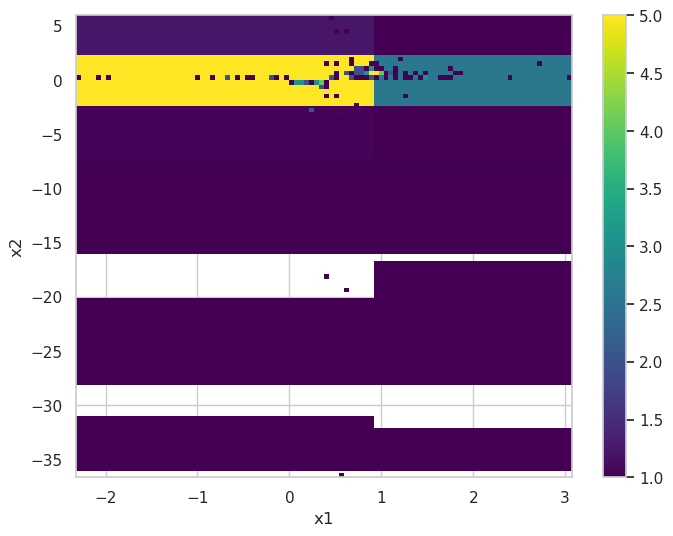

In [21]:
# plot x1 vs x2 in scatter plot. make it a heat map
plt.figure(figsize=(8, 6))

plt.hist2d(ggh_plot['x1'], ggh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(vbfh_plot['x1'], vbfh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(wh_plot['x1'], wh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(zh_plot['x1'], zh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(tth_plot['x1'], tth_plot['x2'], bins=100, cmap='viridis', cmin=1)

# plt.hist2d(vv_plot['x1'], vv_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(top_plot['x1'], top_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(ztt_plot['x1'], ztt_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(ttv_plot['x1'], ttv_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(w_plot['x1'], w_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(zll_plot['x1'], zll_plot['x2'], bins=50, cmap='viridis', cmin=3)

# plt.hist2d(data_plot['x1'], data_plot['x2'], bins=50, cmap='viridis', cmin=3)



plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()



In [22]:
print(len(ggh_plot[(ggh_plot['x2']<1) & ggh_plot['x2']>0]))


821


In [23]:
print(len(ggh_plot['x1']))


992


In [122]:
print(len(ggh_plot[ggh_plot['collinear_mass']<0]))
print(len(vbfh_plot[vbfh_plot['collinear_mass']<0]))
print(len(wh_plot[wh_plot['collinear_mass']<0]))
print(len(zh_plot[zh_plot['collinear_mass']<0]))
print(len(tth_plot[tth_plot['collinear_mass']<0]))
print(len(vv_plot[vv_plot['collinear_mass']<0]))
print(len(top_plot[top_plot['collinear_mass']<0]))
print(len(ttv_plot[ttv_plot['collinear_mass']<0]))
print(len(w_plot[w_plot['collinear_mass']<0]))
print(len(data_plot[data_plot['collinear_mass']<0]))
print(len(ztt_plot[ztt_plot['collinear_mass']<0]))
print(len(zll_plot[zll_plot['collinear_mass']<0]))




0
0
0
0
0
0
0
0
0
0
0
0


In [96]:
len(vbfh_plot), len(ggh_plot), len(wh_plot), len(zh_plot), len(tth_plot), len(vv_plot), len(top_plot), len(ztt_plot), len(ttv_plot), len(w_plot), len(zll_plot)

(1192, 480, 86, 92, 47, 5174, 34, 108130, 51, 31, 1387)

In [97]:
len(ggh_plot['event_number'])

480

In [98]:
ids = ggh_plot['event_number'] % 5 
#print count how mant ids equal 0, 1, 2, 3, 4
print("ggh", len(ggh_plot[ids == 0])+len(ggh_plot[ids == 1])+len(ggh_plot[ids == 2])+len(ggh_plot[ids == 3])+len(ggh_plot[ids == 4]))

ggh 480


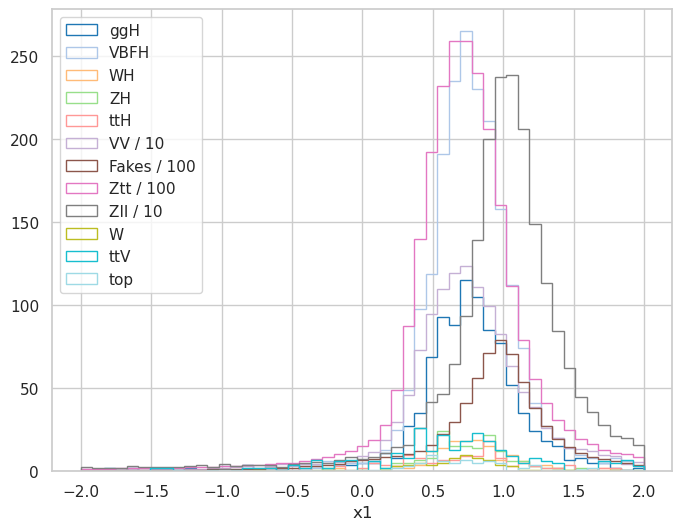

In [26]:
plt.figure(figsize=(8, 6))
plot_int = 'x1'
plt_bins = np.linspace(-2, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

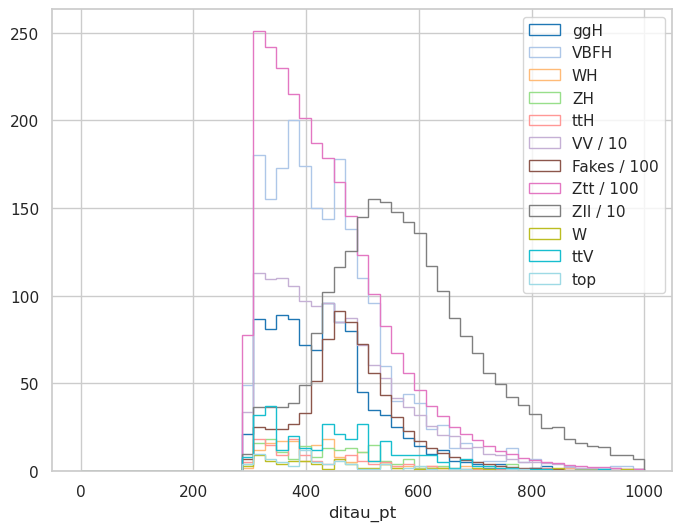

In [72]:
plt.figure(figsize=(8, 6))
plot_int = 'ditau_pt'
plt_bins = np.linspace(0, 1000, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
# plt.hist(np.log(ggh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
# plt.hist(np.log(vbfh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
# plt.hist(np.log(wh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
# plt.hist(np.log(zh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
# plt.hist(np.log(tth_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
# plt.hist(np.log(vv_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
# plt.hist(np.log(data_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
# plt.hist(np.log(ztt_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
# plt.hist(np.log(zll_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
# plt.hist(np.log(w_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
# plt.hist(np.log(ttv_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
# plt.hist(np.log(top_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])


plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

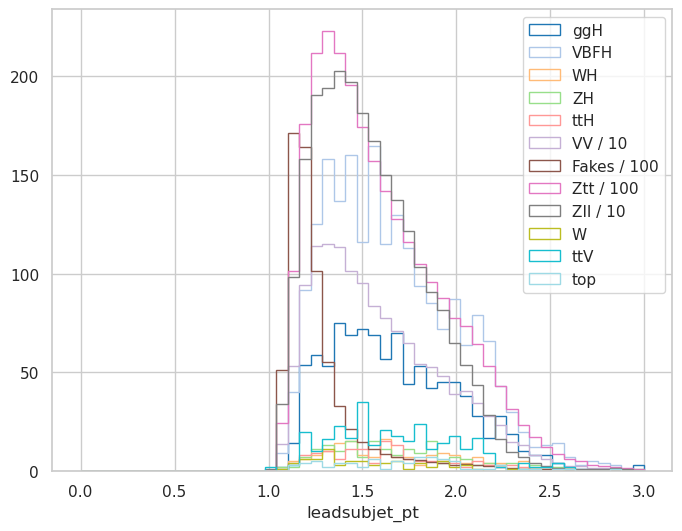

In [77]:
plt.figure(figsize=(8, 6))
plot_int = 'leadsubjet_pt'
plt_bins = np.linspace(0, 3, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot['ditau_pt']/ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot['ditau_pt']/vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot['ditau_pt']/wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot['ditau_pt']/zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot['ditau_pt']/tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot['ditau_pt']/vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot['ditau_pt']/data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot['ditau_pt']/ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot['ditau_pt']/zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot['ditau_pt']/w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot['ditau_pt']/ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot['ditau_pt']/top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

In [66]:
np.log(1 - ggh_plot['ditau_pt']/ggh_plot[plot_int])

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
989   NaN
990   NaN
991   NaN
992   NaN
993   NaN
Length: 994, dtype: float64

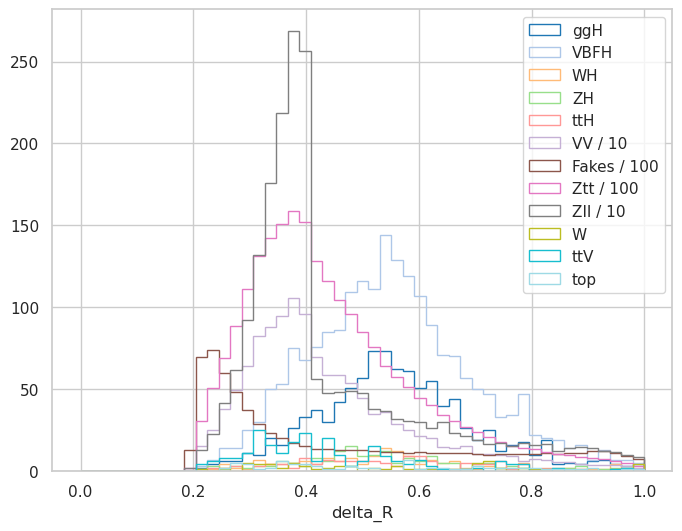

In [21]:
plt.figure(figsize=(8, 6))
plot_int = 'delta_R'
plt_bins = np.linspace(0, 1, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

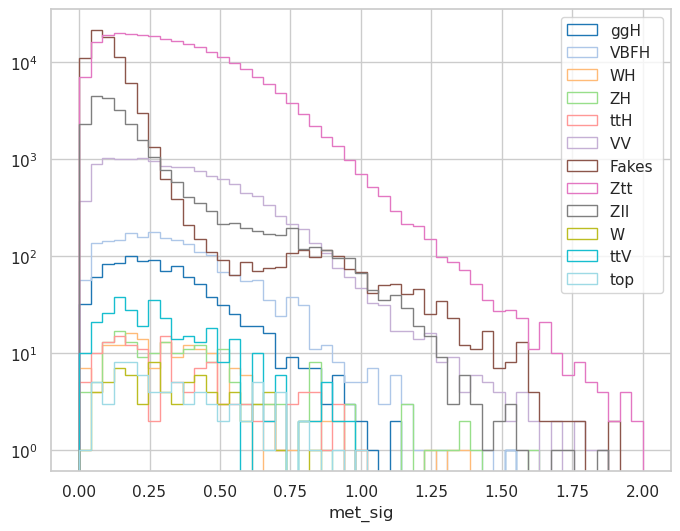

In [28]:
plt.figure(figsize=(8, 6))
plot_int = 'met_sig'
plt_bins = np.linspace(0, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV ', color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes ', color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt ', color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll ', color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

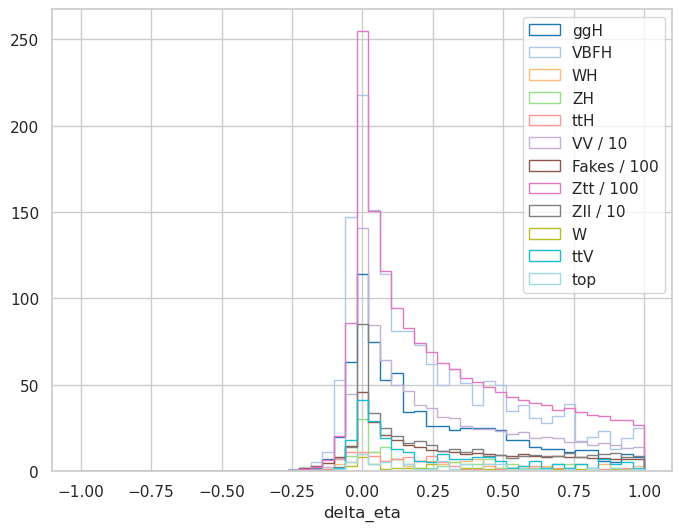

In [49]:
plt.figure(figsize=(8, 6))
plot_int = 'delta_eta'
plt_bins = np.linspace(-1, 1, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100',  weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

In [47]:
# # plot_var = [
# #     'leadsubjet_pT', 'subleadsubjet_pT',
# #     'ditau_m', 'leadsubjet_eta', 'subleadsubjet_eta',
# #     'leadsubjet_phi', 'subleadsubjet_phi'
# # ]
# plot_var = [
# 'leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta'
# ]

# plt.figure(figsize=(40, 36))
# def hist(variable, plot_num):
#     print("Start Plot:", variable)
#     plt.subplot(3, 3, plot_num+1)
#     bin = 50
#     plt.hist(ggh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'ggH ')
#     plt.hist(vbfh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VBFH ')
#     plt.hist(vv_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VV ')
#     # plt.hist(ztt_plot[i], bins=bin, histtype='step', linewidth=1, label=f'Ztt ', weights=np.ones_like(ztt_plot[i])/10)
#     plt.xlabel(variable)
#     #plt.ylabel("Number of Events (scaled)")
#     #plt.title(xlabel)
# #     plt.yscale('log')
#     plt.legend()
#     plt.grid(True)

# for i, label in enumerate(plot_var, 0):
#     hist(label, i)

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


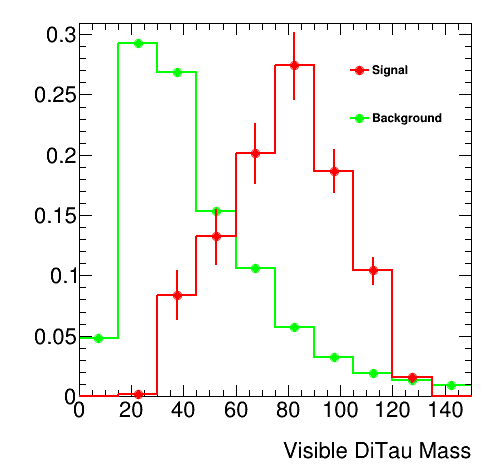

In [47]:
ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

# ggh_plt = plt_to_root_hist_w(ggh_plot[2], 10, 0, 150, None, False)
# ggh_plt.SetLineColor(ROOT.kRed)
# ggh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot[2], 10, 0, 150, None, False)
# vbfh_plt.SetLineColor(ROOT.kBlue)
# vbfh_plt.SetMarkerColor(ROOT.kBlue)
# vv_plt = plt_to_root_hist_w(vv_plot[2], 10, 0, 150, None, False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# ztt_plt = plt_to_root_hist_w(ztt_plot[2], 10, 0, 150, None, False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['visible_ditau_m'], vbfh_plot['visible_ditau_m'], wh_plot['visible_ditau_m'], zh_plot['visible_ditau_m'], tth_plot['visible_ditau_m']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 150, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['visible_ditau_m'], ztt_plot['visible_ditau_m'], w_plot['visible_ditau_m'], top_plot['visible_ditau_m'], zll_plot['visible_ditau_m'], ttv_plot['visible_ditau_m'], data_plot['visible_ditau_m']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['visible_ditau_m'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 150, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

# ggh_plt = plt_to_root_hist_w(ggh_plot['visible_ditau_m'], 20, 0, 150, ggh_plot['combined_weights']*lumi_scale_factor, False)
# ggh_plt.SetLineColor(ROOT.kBlue)
# ggh_plt.SetMarkerColor(ROOT.kBlue)
# ggh_plt.SetMarkerStyle(20)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot['visible_ditau_m'], 20, 0, 150, vbfh_plot['combined_weights']*lumi_scale_factor, False)
# vbfh_plt.SetLineColor(ROOT.kRed)
# vbfh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt.SetMarkerStyle(20)
# vh_plt = plt_to_root_hist_w(vh_plot['visible_ditau_m'], 20, 0, 150, vh_plot['combined_weights']*lumi_scale_factor, False)
# vh_plt.SetLineColor(ROOT.kYellow)
# vh_plt.SetMarkerColor(ROOT.kYellow)
# vh_plt.SetMarkerStyle(20)
# wh_plt = plt_to_root_hist_w(wh_plot['visible_ditau_m'], 20, 0, 150, wh_plot['combined_weights']*lumi_scale_factor, False)
# wh_plt.SetLineColor(ROOT.kGreen)
# wh_plt.SetMarkerColor(ROOT.kGreen)
# wh_plt.SetMarkerStyle(20)
# zh_plt = plt_to_root_hist_w(zh_plot['visible_ditau_m'], 20, 0, 150, zh_plot['combined_weights']*lumi_scale_factor, False)
# zh_plt.SetLineColor(ROOT.kOrange)
# zh_plt.SetMarkerColor(ROOT.kOrange)
# zh_plt.SetMarkerStyle(20)
# tth_plt = plt_to_root_hist_w(tth_plot['visible_ditau_m'], 20, 0, 150, tth_plot['combined_weights']*lumi_scale_factor, False)
# tth_plt.SetLineColor(ROOT.kMagenta)
# tth_plt.SetMarkerColor(ROOT.kMagenta)
# tth_plt.SetMarkerStyle(20)

# vv_plt = plt_to_root_hist_w(vv_plot['visible_ditau_m'], 20, 0, 150, vv_plot['combined_weights'], False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# vv_plt.SetMarkerStyle(20)
# ztt_plt = plt_to_root_hist_w(ztt_plot['visible_ditau_m'], 20, 0, 150, ztt_plot['combined_weights'], False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)
# ztt_plt.SetMarkerStyle(20)
# w_plt = plt_to_root_hist_w(W_plot['visible_ditau_m'], 20, 0, 150, W_plot['combined_weights'], False)
# w_plt.SetLineColor(ROOT.kBlack)
# w_plt.SetMarkerColor(ROOT.kBlack)
# w_plt.SetMarkerStyle(20)
# top_plt = plt_to_root_hist_w(Top_plot['visible_ditau_m'], 20, 0, 150, Top_plot['combined_weights'], False)
# top_plt.SetLineColor(ROOT.kGray)
# top_plt.SetMarkerColor(ROOT.kGray)
# top_plt.SetMarkerStyle(20)
# zll_inc_plt = plt_to_root_hist_w(Zll_inc_plot['visible_ditau_m'], 20, 0, 150, Zll_inc_plot['combined_weights'], False)
# zll_inc_plt.SetLineColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerStyle(20)

# ggh_plt.Scale(1. / ggh_plt.Integral())
# vbfh_plt.Scale(1. / vbfh_plt.Integral())
# vv_plt.Scale(1. / vv_plt.Integral())
# ztt_plt.Scale(1. / ztt_plt.Integral())

# ztt_plt.Draw("hist e ")
# zll_inc_plt.Draw("hist e same")
# vv_plt.Draw("hist e same")
# top_plt.Draw("hist e same")
# w_plt.Draw("hist e same")
# vbfh_plt.Draw("hist e same")
# ggh_plt.Draw("hist e same")
# zh_plt.Draw("hist e same")
# wh_plt.Draw("hist e same")
# tth_plt.Draw("hist e same")
# vh_plt.Draw("hist e same")

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_background.Draw("hist e")
all_signal.Draw("hist e same")

all_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
# legend.AddEntry(vv_plt, "VV")
# legend.AddEntry(ztt_plt, "Ztt")
# legend.AddEntry(w_plt, "W")
# legend.AddEntry(top_plt, "Top")
# legend.AddEntry(zll_inc_plt, "Zll_inc")

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [ ]:
%jsroot on

ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['collinear_mass'], vbfh_plot['collinear_mass'], wh_plot['collinear_mass'], zh_plot['collinear_mass'], tth_plot['collinear_mass']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 200, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['collinear_mass'], ztt_plot['collinear_mass'], w_plot['collinear_mass'], top_plot['collinear_mass'], zll_plot['collinear_mass'], ttv_plot['collinear_mass'], data_plot['collinear_mass']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['collinear_mass'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 200, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_signal.Draw("hist e same")
all_background.Draw("hist e same")

all_background.GetXaxis().SetTitle('Collinear Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [43]:
s = (0.1 + 0.001) * np.log(1 + 0.1 / 0.001) - 0.1
s = np.sqrt(2 * s)
s

0.855718612864027

In [26]:
significance_bin_by_bin(all_signal, all_background, s_much_less_than_b=False)

NameError: name 'significance_bin_by_bin' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


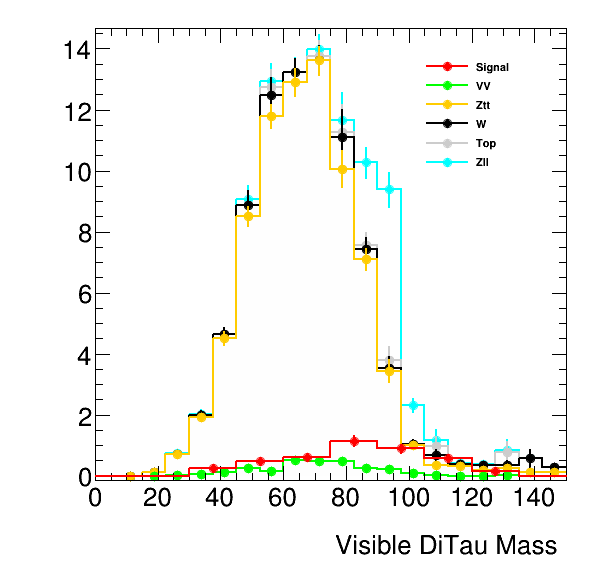

In [21]:
# make root fplot of all signal stracked together and all background stacked together
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#stacked signal
# stacked_signal = ROOT.THStack("stacked_signal", "stacked_signal")
# stacked_signal.Add(ggh_plt)
# stacked_signal.Add(vbfh_plt)
# stacked_signal.Add(vh_plt)
# stacked_signal.Add(wh_plt)
# stacked_signal.Add(zh_plt)
# stacked_signal.Add(tth_plt)

#stacked background
stacked_background = ROOT.THStack("stacked_background", "stacked_background")
stacked_background.Add(vv_plt)
stacked_background.Add(ztt_plt)
stacked_background.Add(w_plt)
stacked_background.Add(top_plt)
stacked_background.Add(zll_inc_plt)

stacked_background.Draw("hist e")
all_signal.Draw("hist e same")

stacked_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
legend.AddEntry(all_signal, "Signal")
legend.AddEntry(vv_plt, "VV")
legend.AddEntry(ztt_plt, "Ztt")
legend.AddEntry(w_plt, "W")
legend.AddEntry(top_plt, "Top")
legend.AddEntry(zll_inc_plt, "Zll")
#make legend text size bigger
legend.SetTextSize(0.02)
#sapce out the markers in the legend
legend.SetMargin(0.5)
#sepreate markers in the legend
legend.SetEntrySeparation(0.1)


legend.Draw()

canvas.Draw()


In [21]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0

data_plot['label'] = 0

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot])
# training_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'visible_ditau_m', 'k_t', 'delta_R', 'combined_weights', 'label'
# ]
training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'delta_R_lead', 'x1', 'x2', 'met_centrality'
]

df = df[training_var]

# df['combined_weights'] = abs(df['combined_weights'])

# df['delta_R'] = np.log(1/df['delta_R'])
# df['k_t'] = np.log(df['k_t'])
# df['met'] =  np.log(df['met'])

# df['pt_ratio'] =  np.log(df['ditau_pt']/df['leadsubjet_pt'])


#drop weight column
# df = df.drop(columns=['combined_weights'])
df

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,collinear_mass,delta_R,delta_phi,delta_eta,label,met,met_sig,event_number,fake_factor,combined_weights,k_t,delta_R_lead,x1,x2,met_centrality
0,538.078688,454.704156,25.682889,33.888864,44.644235,0.237291,-0.075515,0.224954,0,44.850841,0.091293,480494748.0,0.004711,1.000000,6.094310,0.024447,1.261332,0.340896,-0.418356
1,508.921094,413.315250,24.097494,37.579012,64.389632,0.353011,-0.125690,0.329877,0,8.423738,0.016643,504447465.0,0.003944,1.000000,8.506678,0.027496,1.184453,0.281727,-0.032899
2,492.924937,365.323438,10.964622,31.198884,83.743483,0.384571,0.335235,-0.188446,0,78.134463,0.155826,428336028.0,0.003944,1.000000,4.216670,0.006159,1.980624,0.047179,0.141881
3,429.751781,342.924906,17.127457,33.264732,46.648418,0.352273,-0.306564,-0.173537,0,35.925599,0.073605,441195059.0,0.003944,1.000000,6.033547,0.050619,0.954874,0.459574,1.406000
4,457.772500,381.131844,10.149227,53.754080,59.119526,0.851922,-0.805664,-0.276906,0,20.009019,0.039762,448125636.0,0.003944,1.000000,8.646350,0.031083,0.952865,0.862389,1.081917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,640.735688,498.938750,107.536055,90.249961,129.169264,0.390626,0.383033,-0.076649,0,111.027325,0.182528,1603705.0,1.000000,0.014541,42.006425,0.051541,1.009782,0.482156,0.957315
14965,480.589938,348.642406,86.100773,93.775520,52.433130,0.545621,-0.542826,-0.055156,0,96.113806,0.124196,1259165.0,1.000000,0.014366,46.978363,0.077489,1.145920,2.797587,-1.405797
14966,435.068562,336.510438,58.670461,89.289148,70.564674,0.644442,-0.640265,0.073256,0,77.454754,0.163087,1156711.0,1.000000,0.014731,37.809738,0.092350,1.247004,1.284122,-1.172720
14967,440.468750,365.536906,10.820838,18.974888,79.999769,0.274983,0.200785,0.187886,0,241.067679,0.471250,1663330.0,1.000000,0.014607,2.975549,0.022454,0.867185,0.054992,1.245833


In [22]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    243270
1      3061
Name: count, dtype: int64

In [23]:
df.loc[df['combined_weights'] < 0, 'combined_weights']

Series([], Name: combined_weights, dtype: float64)

In [24]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [25]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 82245 81702 82384 0 0
Signal Split: 1033 988 1040 0 0
Background Split: 81212 80714 81344 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'event_number', 'fake_factor', 'combined_weights', 'k_t',
       'delta_R_lead', 'x1', 'x2', 'met_centrality', 'ids'],
      dtype='object')


len X_train: 164086
len X_test: 82245
signal scaling factor:  79.91025641025641
len X_train: 164629
len X_test: 81702
signal scaling factor:  78.41582247949832
len X_train: 163947
len X_test: 82384
signal scaling factor:  80.12172191984166


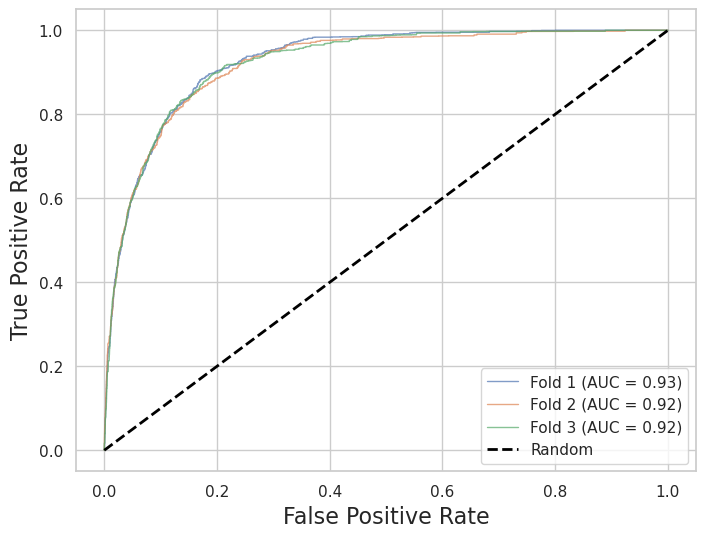

In [26]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []


bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'label': 'label',
    'met': 'f5',
    'met_sig': 'f6',
    'event_number': 'event_number',
    'fake_factor': 'fake_factor',
    'combined_weights': 'combined_weights',
    'ids': 'ids',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
    'delta_R_lead': 'f10',
    'delta_phi': 'f11',
    'delta_eta': 'f12',
    'k_t': 'f13'
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]

    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.065, 'max_depth': 6, 'n_estimators': 250,
    # 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }
    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=ff_train*evnt_w_train)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])
    
    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=ff_test*evnt_w_test)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



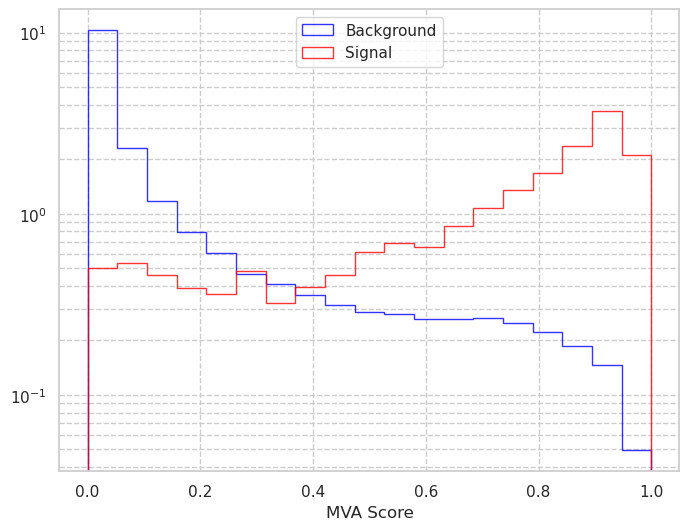

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 20), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 20), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [36]:
sig_hist = plt_to_root_hist_w(signal_scores, 10, 0., 1., None, False)
bkg_hist = plt_to_root_hist_w(background_scores, 10, 0., 1., None, False)
sig_hist.Scale(1/sig_hist.Integral())
bkg_hist.Scale(1/bkg_hist.Integral())
significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)

bin 1, signal = 0.04078722190530519, background = 0.5769389526590224, significance = 0.053083367368570326
bin 2, signal = 0.030804335424985736, background = 0.12279274740350003, significance = 0.08457007010408099
bin 3, signal = 0.038790644609241295, background = 0.07184610995441329, significance = 0.133970937388587
bin 4, signal = 0.04506560182544209, background = 0.05284051936069345, significance = 0.17502065642113784
bin 5, signal = 0.05362236166571591, background = 0.04233918696620756, significance = 0.2231443002085824
bin 6, signal = 0.062179121505989726, background = 0.03655738401490825, significance = 0.268039778360884
bin 7, signal = 0.0975470621791215, background = 0.032368991325778036, significance = 0.4074203369945224
bin 8, signal = 0.14945807187678264, background = 0.030256584578216717, significance = 0.5843487267711157
bin 9, signal = 0.22304620650313747, background = 0.02426839705962693, significance = 0.8379632998329095
bin 10, signal = 0.2586993725042784, background = 

1.6280521231445728

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [62]:
# # Initialize k-fold cross-validation
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# # Initialize lists to store scores
# signal_scores = []
# background_scores = []
# proba_and_values = []
# models = []

# training_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'visible_ditau_m', 'delta_R', 'met', 'label'
# ]
# X = df[training_var[:-1]]  # Features
# print(X.columns)
# y = df['label']  # Target variable

# scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
# print(scale_pos_weight)
# plt.figure(figsize=(8, 6))

# # Iterate through each fold
# # for train_index, test_index in kf.split(X):
# for i, (train_index, test_index) in enumerate(kf.split(X, y)):
#     # Split train and test sets
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     #change column names to f1, f2, f3, f4, f5
#     X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
#     X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
    
#     params = {
#     'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
#     model = XGBClassifier(**params)
#     # Train the model
#     model.fit(X_train, y_train)
#     models.append(model)

#     # Predict probabilities for the test set
#     y_pred_proba = model.predict_proba(X_test)
#     # Extract scores for signal and background
#     signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
#     background_scores.extend(y_pred_proba[:, 1][y_test == 0])

#     # save the proba correspoending to the X_test values
#     proba_and_values.append((y_pred_proba, X_test))

#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')


# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Each Fold')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


In [109]:
# from sklearn.model_selection import cross_val_predict

# params = {
#     'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# model_n = XGBClassifier(**params)

# # Perform cross-validation predictions
# y_pred_proba_cv = cross_val_predict(model_n, X, y, cv=5, method='predict_proba')

# # Get the predicted probabilities for the positive class
# positive_class_proba = y_pred_proba_cv[:, 1]


In [110]:
# plt.figure(figsize=(8, 6))
# plt.hist(positive_class_proba[y == 1], bins=10, alpha=0.8, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(positive_class_proba[y == 0], bins=10, alpha=0.8, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

# sig_hist = plt_to_root_hist_w(positive_class_proba[y == 1], 10, 0., 1., None, False)
# bkg_hist = plt_to_root_hist_w(positive_class_proba[y == 0], 10, 0., 1., None, False)
# sig_hist.Scale(1/sig_hist.Integral())
# bkg_hist.Scale(1/bkg_hist.Integral())
# significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False) ###0.99 with False

In [72]:
import xgboost as xgb
def get_basescore(model: xgb.XGBModel) -> float:
    import json

    """Get base score from an XGBoost sklearn estimator."""
    base_score = float(json.loads(model.get_booster().save_config())["learner"]["learner_model_param"]["base_score"])
    return base_score

print(get_basescore(model)) # usually 0.5

0.5


In [115]:
# # Load the XGBoost model
# trained_model = XGBClassifier()
# trained_model.load_model('xgboost_k_fold_model_v05.bin')

# # calucalte score values with X_train
# y_pred_proba_now = trained_model.predict_proba(X)

# k_fold_y_pred_proba_signal = y_pred_proba_now[:, 1][y == 1]
# k_fold_y_pred_proba_background = y_pred_proba_now[:, 1][y == 0]

In [106]:
%jsroot on
ROOT.gROOT.SetStyle("ATLAS")

# plot sig_hist and bkg_hist
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#plot signal
sig_hist.SetLineColor(ROOT.kRed)
sig_hist.SetMarkerColor(ROOT.kRed)
sig_hist.SetMarkerStyle(20)
#plot background
bkg_hist.SetLineColor(ROOT.kBlue)
bkg_hist.SetMarkerColor(ROOT.kBlue)
bkg_hist.SetMarkerStyle(20)

#set y axis range 
# bkg_hist.GetYaxis().SetRangeUser(0, 0.42)

sig_hist.Draw("hist e")
bkg_hist.Draw("hist e same")

sig_hist.GetXaxis().SetTitle('Score')

legend = ROOT.TLegend(0.3, 0.7, 0.6, 0.6)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.AddEntry(sig_hist, "Signal")
legend.AddEntry(bkg_hist, "Background")


legend.Draw()

canvas.Draw()



Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [128]:
# #split the data into training and testing
# # training_var_s = [
# #     'leadsubjet_pT', 'subleadsubjet_pT',
# #     'visible_ditau_m', 'delta_R'
# # ]
# training_var_s = ['leadsubjet_pT',
#     'subleadsubjet_pT',
#     'visible_ditau_m',
#     'collinear_mass',
#     'delta_R',
#     'met',
#     'met_sig',
#     'delta_phi',
#     'delta_eta'
# ]
# X = df[training_var_s]
# y = df['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

# # print(X_train)
# #save weights in a separate variable
# # weights_train = np.abs(X_train['combined_weights']*lumi_scale_factor)
# # weights_test = np.abs(X_test['combined_weights']*lumi_scale_factor)

# # weights should not be included in the training data
# # X_train.drop(columns='combined_weights', inplace=True)
# # X_test.drop(columns='combined_weights', inplace=True)

# #Change column names to integers if needed (for ML models that expect numerical feature names)
# # feature_mapping = {feature: i for i, feature in enumerate(X_train.columns)}
# # X_train.rename(columns=feature_mapping, inplace=True)
# # X_test.rename(columns=feature_mapping, inplace=True)

# # istead of integers call the vaibels f1, f2, f3, f4
# # X_train.columns = ['f0', 'f1', 'f2', 'f3']
# # X_test.columns = ['f0', 'f1', 'f2', 'f3']
# print(X_train.shape)
# print(X_test.shape)

# #print size of training and testing data
# # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, weights_train.shape, weights_test.shape)
# print(X_train)


In [129]:
# # create the BDT
# params = {
#     'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# bdt = XGBClassifier(**params)

# # Train the classifier
# # bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)], sample_weight=weights_train)
# bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)])


In [130]:
# # plot the ROC curve
# # print(bdt.predict_proba(X_test).shape)
# # print(bdt.predict_proba(X_test))
# print(X_test)
# y_pred = bdt.predict_proba(X_test)[:, 1]
# print(y_pred)
# # fpr, tpr, thresholds = roc_curve(y_test, y_pred, sample_weight=weights_test)
# # roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'(AUC={roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(tpr, 1/fpr, lw=1)
# plt.xlabel('Signal efficiency (TPR)')
# plt.ylabel('Inverse background efficiency (1/FPR)')
# plt.yscale('log')
# plt.grid(True, which="both", ls="--")
# plt.show()

# print(len(y_pred[y_test == 1]), len(y_pred[y_test == 0]))

# signal_scores = y_pred[y_test == 1]
# background_scores = y_pred[y_test == 0]
# plt.figure(figsize=(8, 6))
# plt.hist(signal_scores, bins=10, alpha=0.5, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(background_scores, bins=10, alpha=0.5, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

In [37]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from torch.utils.data import TensorDataset, DataLoader
# import time

# learning_rate = 0.00001
# batch_size = 64
# dropout = 0
# neuron1 = 64
# neuron2 = 128
# neuron3 = 256
# neuron4 = 128
# neuron5 = 64

# num_epochs = 100

# training_vars = [
#     'leadsubjet_pt',
#     'subleadsubjet_pt',
#     'visible_ditau_m',
#     'collinear_mass',
#     'delta_R',
#     'delta_R_lead',
#     'met',
#     'met_sig',
#     'delta_phi',
#     'delta_eta',
#     'k_t'
# ]


# # Split the dataset into training and validation sets
# df['eventID_mod'] = df['event_number'] % 10

# train_loc = df['eventID_mod'] < 7 # 70%
# test_loc = df['eventID_mod'] >= 7 # 30%

# features, labels = df[training_vars].values, df['label'].values
# X_train, X_val, y_train, y_val= features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]


# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     print("Using GPU")

# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
#         super(MLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, neuron1),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron1, neuron2),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron2, neuron3),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron3, neuron4),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron4, neuron5),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron5, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.layers(x)

# # Convert data to PyTorch tensors and move to GPU if available
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# # Create DataLoader for batch training
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# # Initialize the MLP model and move to GPU if available
# model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)

# # Define the loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch: {epoch+1}, Loss: {loss.item()}')



In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
learning_rate = 0.00008
batch_size = 128
dropout = 0
neuron1 = 64
neuron2 = 512
neuron3 = 64
neuron4 = 64
neuron5 = 0
num_epochs =  40

training_vars = [
    'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass',
    'delta_R', 'delta_R_lead', 'met', 'met_sig', 'delta_phi', 'delta_eta', 'pt_ratio'
]

# Split the dataset into training and validation sets
df['eventID_mod'] = df['event_number'] % 10
train_loc = df['eventID_mod'] < 7  # 70%
test_loc = df['eventID_mod'] >= 7  # 30%

features, labels = df[training_vars].values, df['label'].values
X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

print("len X_train:", len(X_train))
print("len X_val:", len(X_val))

event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]


# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
# X_train_scaled = X_train
# X_val_scaled = X_val

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, neuron1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron1, neuron2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron2, neuron3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron3, neuron4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron4, 1),
            # nn.GELU(),
            # nn.Dropout(dropout),
            # nn.Linear(neuron5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader for batch training
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize the MLP model and move to GPU if available
model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)

# Calculate class weights
n_background = np.sum(y_train == 0)
n_signal = np.sum(y_train == 1)
# weight_for_0 = (1 / n_background) * ((n_background + n_signal) / 2)
# weight_for_1 = (1 / n_signal) * ((n_background + n_signal) / 2)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([n_background / n_signal]).to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early stopping function
def early_stopping(val_loss_list, patience=5):
    if len(val_loss_list) > patience:
        if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
            return True
    return False

# Training loop
best_val_loss = float('inf')
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
    
    val_loss_list.append(val_loss)
    scheduler.step(val_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if early_stopping(val_loss_list):
        print("Early stopping")
        break



len X_train: 262249
len X_val: 112267
Using GPU
Epoch: 1, Train Loss: 0.9639, Val Loss: 0.8232
Epoch: 2, Train Loss: 0.8117, Val Loss: 0.7920
Epoch: 3, Train Loss: 0.7892, Val Loss: 0.7853
Epoch: 4, Train Loss: 0.7776, Val Loss: 0.7640
Epoch: 5, Train Loss: 0.7688, Val Loss: 0.7516
Epoch: 6, Train Loss: 0.7602, Val Loss: 0.7504
Epoch: 7, Train Loss: 0.7552, Val Loss: 0.7542
Epoch: 8, Train Loss: 0.7495, Val Loss: 0.7550
Epoch: 9, Train Loss: 0.7459, Val Loss: 0.7415
Epoch: 10, Train Loss: 0.7412, Val Loss: 0.7424
Epoch: 11, Train Loss: 0.7372, Val Loss: 0.7349
Epoch: 12, Train Loss: 0.7349, Val Loss: 0.7363
Epoch: 13, Train Loss: 0.7324, Val Loss: 0.7306
Epoch: 14, Train Loss: 0.7297, Val Loss: 0.7314
Epoch: 15, Train Loss: 0.7265, Val Loss: 0.7438
Epoch: 16, Train Loss: 0.7269, Val Loss: 0.7333
Epoch: 17, Train Loss: 0.7247, Val Loss: 0.7272
Epoch: 18, Train Loss: 0.7224, Val Loss: 0.7309
Epoch: 19, Train Loss: 0.7204, Val Loss: 0.7352
Epoch: 20, Train Loss: 0.7193, Val Loss: 0.7198
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
learning_rate = 0.00008
batch_size = 128
dropout = 0
neuron1 = 64
neuron2 = 512
neuron3 = 64
neuron4 = 64
neuron5 = 0
num_epochs =  40

training_vars = [
    'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass',
    'delta_R', 'delta_R_lead', 'met', 'met_sig', 'delta_phi', 'delta_eta', 'k_t'
]

# Split the dataset into training and validation sets
df['eventID_mod'] = df['event_number'] % 10
train_loc = df['eventID_mod'] < 7  # 70%
test_loc = df['eventID_mod'] >= 7  # 30%

features, labels = df[training_vars].values, df['label'].values
X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]


# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
# X_train_scaled = X_train
# X_val_scaled = X_val

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, neuron1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron1, neuron2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron2, neuron3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron3, neuron4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron4, 1),
            # nn.GELU(),
            # nn.Dropout(dropout),
            # nn.Linear(neuron5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
event_weight_train_tensor = torch.tensor(event_weight_train, dtype=torch.float32).view(-1, 1).to(device)
event_weight_val_tensor = torch.tensor(event_weight_val, dtype=torch.float32).view(-1, 1).to(device)



# Create DataLoader for batch training
train_data = TensorDataset(X_train_tensor, y_train_tensor, event_weight_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize the MLP model and move to GPU if available
model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)

# Calculate class weights
n_background = np.sum(y_train == 0)
n_signal = np.sum(y_train == 1)
# weight_for_0 = (1 / n_background) * ((n_background + n_signal) / 2)
# weight_for_1 = (1 / n_signal) * ((n_background + n_signal) / 2)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([n_background / n_signal]).to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early stopping function
def early_stopping(val_loss_list, patience=5):
    if len(val_loss_list) > patience:
        if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
            return True
    return False

# Training loop
best_val_loss = float('inf')
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels, batch_weights in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss = (loss * batch_weights).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
    
    val_loss_list.append(val_loss)
    scheduler.step(val_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if early_stopping(val_loss_list):
        print("Early stopping")
        break



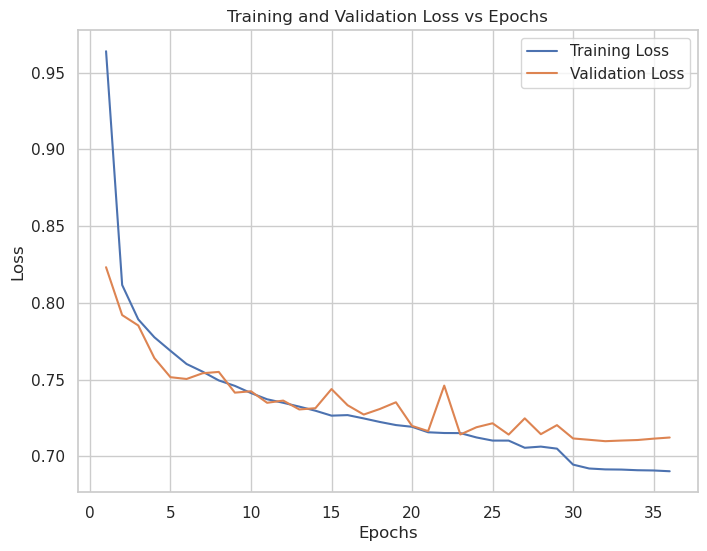

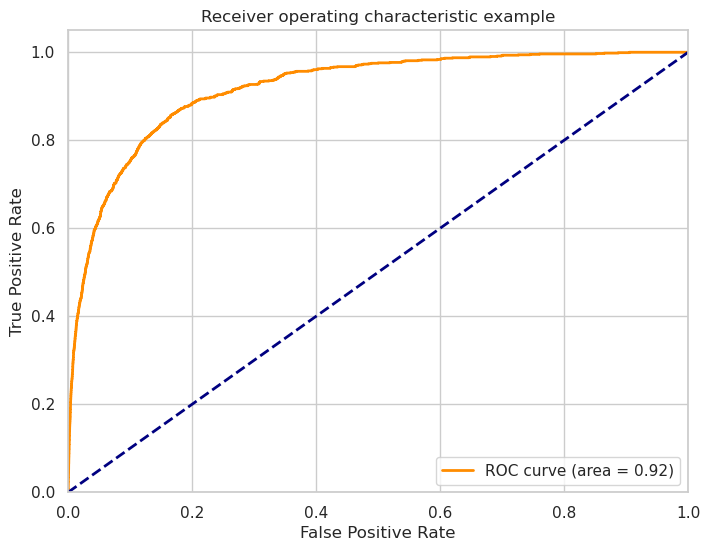

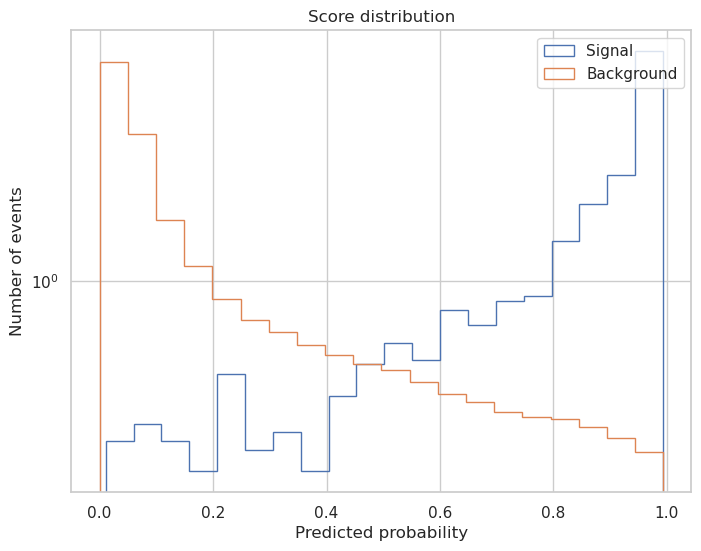

In [85]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# After training the model, get the predicted probabilities for the validation set
model.eval()
with torch.no_grad():
    y_val_pred = torch.sigmoid(model(X_val_tensor))

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_val_pred.cpu().numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot the score distribution for signal and background
plt.figure(figsize=(8, 6))
plt.hist(y_val_pred[y_val == 1].cpu().numpy(), bins=20, label='Signal', histtype='step', density=True)
plt.hist(y_val_pred[y_val == 0].cpu().numpy(), bins=20, label='Background', histtype='step', density=True)
plt.yscale('log')
plt.xlabel('Predicted probability')
plt.ylabel('Number of events')
plt.title('Score distribution')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="--")
plt.show()


In [87]:

# Export the model
torch.onnx.export(model,               # model being run
                  X_val_tensor,                         # model input (or a tuple for multiple inputs)
                  "mva_mlp.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['X'],   # the model's input names
                  output_names = ['Y'], # the model's output names
                  dynamic_axes={'X' : {0 : 'batch_size'},    # variable length axes
                                'Y' : {0 : 'batch_size'}})

In [88]:
import onnx

onnx_model = onnx.load("mva_mlp.onnx")
onnx.checker.check_model(onnx_model)

In [94]:
import onnxruntime

torch_out = model(X_val_tensor)

ort_session = onnxruntime.InferenceSession("mva_mlp.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(X_val_tensor)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


[array([[-4.904828 ],
       [ 3.1654897],
       [-2.3223598],
       ...,
       [-0.8264936],
       [ 1.7189206],
       [-1.1022711]], dtype=float32)]
Exported model has been tested with ONNXRuntime, and the result looks good!


In [95]:
torch_out

tensor([[-4.9048],
        [ 3.1655],
        [-2.3224],
        ...,
        [-0.8265],
        [ 1.7189],
        [-1.1023]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [63]:
sig_hist_mlp = plt_to_root_hist_w(y_val_pred[y_val == 1].cpu().numpy(), 5, 0., 1., None, False)
bkg_hist_mlp = plt_to_root_hist_w(y_val_pred[y_val == 0].cpu().numpy(), 5, 0., 1., None, False)
sig_hist_mlp.Scale(1/sig_hist_mlp.Integral())
bkg_hist_mlp.Scale(1/bkg_hist_mlp.Integral())

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [64]:
%jsroot on
ROOT.gROOT.SetStyle("ATLAS")

# plot sig_hist and bkg_hist
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#plot signal
sig_hist_mlp.SetLineColor(ROOT.kRed)
sig_hist_mlp.SetMarkerColor(ROOT.kRed)
sig_hist_mlp.SetMarkerStyle(20)
#plot background
bkg_hist_mlp.SetLineColor(ROOT.kBlue)
bkg_hist_mlp.SetMarkerColor(ROOT.kBlue)
bkg_hist_mlp.SetMarkerStyle(20)

sig_hist_mlp.Draw("hist e")
bkg_hist_mlp.Draw("hist e same")
sig_hist_mlp.GetXaxis().SetTitle('Score')
legend = ROOT.TLegend(0.3, 0.7, 0.6, 0.6)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.AddEntry(sig_hist_mlp, "Signal")
legend.AddEntry(bkg_hist_mlp, "Background")
#set log y 
canvas.SetLogy()
legend.Draw()
canvas.Draw()



Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [65]:

# sig_hist_mlp.ROOT.Chi2Test(bkg_hist_mlp,"WW",res)
# res = sig_hist_mlp.Chi2Test(bkg_hist_mlp, "WW P")
chi2 = bkg_hist_mlp.Chi2Test(sig_hist_mlp, "WW P")


Chi2 = 3062.806806, Prob = 0, NDF = 4, igood = 0


In [66]:
chi2

0.0

In [24]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import time

# start = time.time()

# learning_rate = 0.00001
# batch_size = 128
# dropout = 0
# neuron1 = 64
# neuron2 = 128
# neuron3 = 256
# neuron4 = 128
# neuron5 = 64

# training_vars = [
#     'leadsubjet_pt',
#     'subleadsubjet_pt',
#     'visible_ditau_m',
#     'collinear_mass',
#     'delta_R',
#     'met',
#     'met_sig',
#     'delta_phi',
#     'delta_eta',
#     'k_t'
# ]


# # Split the dataset into training and validation sets
# df['eventID_mod'] = df['event_number'] % 10

# train_loc = df['eventID_mod'] < 7 # 70%
# test_loc = df['eventID_mod'] >= 7 # 30%

# # features, labels, weights = df[training_vars].values, df['label'].values, df['weight'].values
# # X_train, X_val, y_train, y_val, weights_train, weights_val = \
# #       features[train_loc], features[test_loc], labels[train_loc], labels[test_loc], weights[train_loc], weights[test_loc] 

# features, labels = df[training_vars].values, df['label'].values
# X_train, X_val, y_train, y_val= features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]
# print(X_train.shape, y_train.shape)
# # weights for imbalnced data
# weights_train = np.full(y_train.shape, len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
# weights_val = np.full(y_val.shape, len(y_val[y_val == 0]) / len(y_val[y_val == 1]))

# # signal_class_weight = (len(y_train[y_train == 0]) + len(y_train[y_train == 1])) / (2 * len(y_train[y_train == 1]))
# # bkg_class_weight = (len(y_train[y_train == 0]) + len(y_train[y_train == 1])) / (2 * len(y_train[y_train == 0]))

# # signal_class_weight = (len(y_train) / (2 * len(y_train[y_train == 1])))
# # bkg_class_weight = (len(y_train) / (2 * len(y_train[y_train == 0])))
# # class_weights = np.array([bkg_class_weight, signal_class_weight])
# class_weights = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])], dtype=torch.float32).to(device)


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if device.type == 'cuda':
#     print("GPU is available")
# else:
#     print("GPU not available, using the CPU instead.")

# # Convert to PyTorch tensors and move to device
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
# weights_train_tensor = torch.tensor(weights_train, dtype=torch.float32).to(device)

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
# weights_val_tensor = torch.tensor(weights_val, dtype=torch.float32).to(device)

# # Define the Dataset
# class SignalBackgroundDataset(Dataset):
#     def __init__(self, features, labels, weights):
#         self.features = features
#         self.labels = labels
#         self.weights = weights

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx], self.weights[idx]

# # Define the DNN model with dropout
# class DNN(nn.Module):
#     def __init__(self, input_size):
#         super(DNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, neuron1)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=dropout)
#         self.fc2 = nn.Linear(neuron1, neuron2)
#         self.fc3 = nn.Linear(neuron2, neuron3)
#         self.fc4 = nn.Linear(neuron3, neuron4)
#         self.fc5 = nn.Linear(neuron4, neuron5)
#         self.fc6 = nn.Linear(neuron5, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc4(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc5(x))
#         x = self.dropout(x)
#         x = self.sigmoid(self.fc6(x))
#         return x

# model = DNN(X_train_tensor.shape[1]).to(device)
# # criterion = nn.BCELoss(reduction='none')
# # criterion = nn.BCEWithLogitsLoss(weight=class_weights)
# criterion = nn.BCELoss(weight=class_weights)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Create DataLoader for training data
# train_dataset = SignalBackgroundDataset(X_train_tensor, y_train_tensor, weights_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = SignalBackgroundDataset(X_val_tensor, y_val_tensor, weights_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# num_epochs = 20
# patience = 6  # How many epochs to wait after last time validation loss improved.
# best_val_loss = np.inf  # Initialize best validation loss to infinity
# epochs_no_improve = 0  # Counter for epochs with no improvement

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct_predictions, total_predictions = 0, 0

#     for inputs, targets, batch_weights in train_loader:
#         inputs, targets, batch_weights = inputs.to(device), targets.to(device), batch_weights.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), targets)
#         # loss = (loss * batch_weights).mean()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # binary classification for accuracy calculation
#         preds = outputs.squeeze().round()
#         correct_predictions += (preds == targets).sum().item()
#         total_predictions += targets.size(0)

#     train_accuracy = correct_predictions / total_predictions
#     avg_training_loss = running_loss / len(train_loader)

#     # Validation phase
#     model.eval()
#     val_running_loss = 0.0
#     correct_predictions, total_predictions = 0, 0

#     with torch.no_grad():
#         for inputs, targets, batch_weights in val_loader:
#             inputs, targets, batch_weights = inputs.to(device), targets.to(device), batch_weights.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs.squeeze(), targets)
#             # loss = (loss * batch_weights).mean()

#             val_running_loss += loss.item()

#             preds = outputs.squeeze().round()
#             correct_predictions += (preds == targets).sum().item()
#             total_predictions += targets.size(0)

#     val_accuracy = correct_predictions / total_predictions
#     avg_val_loss = val_running_loss / len(val_loader)

# #     # Log metrics to W&B
# #     wandb.log({
# #         'epoch': epoch,
# #         'training_loss': avg_training_loss,
# #         'validation_loss': avg_val_loss,
# #         'training_accuracy': train_accuracy,
# #         'validation_accuracy': val_accuracy
# #     })

#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_training_loss:.4e}, Validation Loss: {avg_val_loss:.4e}, Training Accuracy: {train_accuracy:.4e}, Validation Accuracy: {val_accuracy:.4e}")

#     # # Check if the validation loss improved
#     # if avg_val_loss < best_val_loss:
#     #     best_val_loss = avg_val_loss
#     #     epochs_no_improve = 0
#     #     # Save the model
#     #     # torch.save(model.state_dict(), 'best_model.pth')
#     # else:
#     #     epochs_no_improve += 1
#     #     if epochs_no_improve >= patience:
#     #         print(f'Early stopping triggered after {epoch + 1} epochs.')
#     #         break  # Early stopping


# # Evaluate on the validation set
# model.eval()
# val_predictions = []
# with torch.no_grad():
#     for inputs, targets, _ in DataLoader(SignalBackgroundDataset(X_val_tensor, y_val_tensor, torch.tensor(weights_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False):
#         inputs = inputs.to(device)
#         outputs = model(inputs).squeeze()
#         val_predictions.extend(outputs.cpu().numpy())
# val_predictions = np.array(val_predictions)

# # Compute ROC curve and ROC area
# fpr_dnn, tpr_dnn, _ = roc_curve(y_val, val_predictions)
# roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# plt.figure(figsize=(22, 10))
# plt.subplot(121)
# plt.plot(fpr_dnn, tpr_dnn, label='MLP (area = {:.5f})'.format(roc_auc_dnn))
# plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC Curve')
# plt.legend()
# plt.grid(True)

# plt.subplot(122)
# plt.plot(tpr_dnn, 1/fpr_dnn, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)
# plt.xlabel('Signal efficiency (TPR)')
# plt.ylabel('Inverse backround efficiency (1/FPR)')
# plt.yscale('log')
# plt.legend()
# plt.grid(True)
# plt.show()

# print(f'Pytorch Time: {(time.time() - start)/60} min')

In [25]:
# # plot score distribution from MLP
# mlp_signal_scores = val_predictions[y_val == 1]
# mlp_background_scores = val_predictions[y_val == 0]
# plt.figure(figsize=(8, 6))
# plt.hist(mlp_signal_scores, bins=50, alpha=0.5, color='blue', label='Signal', histtype='step')
# plt.hist(mlp_background_scores, bins=50, alpha=0.5, color='red', label='Background', histtype='step')
# plt.xlabel('Score')
# plt.yscale('log')
# plt.legend(loc='upper center')
# # plt.grid(True)
# plt.show()
